In [ ]:
from paths import paths
import json
import torch
from tokenizers import Tokenizer
from pprint import pprint
from PIL import Image
import os
import matplotlib.pyplot as plt
from coco_loader import get_coco_loader
from image_transforms import (
    captioner_image_transform_index,
    encoder_image_transform_index,
)
from image_captioner import ImageAutoEncoder, ImageEncoder, ImageDecoder, CaptionDecoder
from transformer_components import TransformerEncoderDecoder
import yaml

# Set device.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"You are using {device}.")

You are using mps.


In [15]:
# Loading the tokenizer.
tokenizer = Tokenizer.from_file(paths["tokenizer"])

In [16]:
# Example 1: The structure of the downloaded annotation files. Note that "paths["captions"]["val"]" would be similar.

with open(paths["captions"]["train"]) as f:
    annotations = json.load(f)["annotations"]

idx = 7  # Randomly chosen index.
pprint(annotations[idx], width=100)

{'caption': 'A blue boat themed bathroom with a life preserver on the wall',
 'id': 163,
 'image_id': 322141}


In [17]:
# Example 2: The structure of *_tokenized.pt files.

captions = torch.load(paths["captions_tokenized"]["train"], weights_only=False)
pprint(captions[idx], width=100)

{'caption': [0, 40, 293, 399, 3285, 286, 84, 40, 1939, 534, 610, 138, 70, 78, 418, 1],
 'image_id': 322141}


In [18]:
# Example 2 (cont): Decode a caption using the tokenizer.

pprint(tokenizer.decode(captions[idx]["caption"]), width=100)

'a blue boat themed bathroom with a life pre ser ver on the wall'


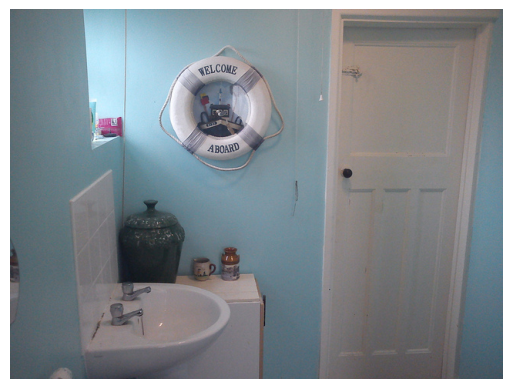

In [19]:
# Example 2 (cont): Read image from disk, and display the image.

image_id = captions[idx]["image_id"]
image_path = os.path.join(paths["images"]["train"], f"{image_id:012}.jpg")

image = Image.open(image_path).convert("RGB")

plt.imshow(image)
plt.axis("off")
plt.show()

In [20]:
type(image)

PIL.Image.Image

In [21]:
# Example 3: The structure of *_image_ids.pt files.

image_ids = torch.load(paths["image_ids"]["train"])
pprint(image_ids[0:10])  # The first 10 image ids.

[203564, 322141, 16977, 106140, 571635, 301837, 315702, 189634, 472598, 162113]


In [22]:
# Example 4: The structure of *_im2capts.pt files.

im2capts = torch.load(paths["image_to_captions"]["train"])

# 1 happens to be the index of the image with image_id = 322141
pprint(im2capts[1], width=120)

(322141,
 [[0, 40, 158, 84, 293, 1156, 76, 40, 160, 409, 76, 484, 17, 1],
  [0, 293, 76, 160, 676, 58, 576, 660, 66, 40, 229, 286, 17, 1],
  [0, 493, 81, 40, 293, 76, 160, 286, 84, 40, 418, 409, 76, 40, 2684, 94, 40, 138, 70, 78, 418, 17, 1],
  [0, 40, 293, 399, 3285, 286, 84, 40, 1939, 534, 610, 138, 70, 78, 418, 1],
  [0, 40, 286, 84, 1156, 181, 121, 1131, 624, 293, 17, 1]])


In [ ]:
# Example 5: Getting a loader for CaptFirstDataset
BATCH_SIZE = 8
PAD_IDX = tokenizer.token_to_id("<PAD>")
CONTEXT_SIZE = 60
NUM_WORKERS = 4

capt_first_loader = get_coco_loader(
    "train",
    BATCH_SIZE,
    captioner_image_transform_index["train"],
    NUM_WORKERS,
    CONTEXT_SIZE,
    PAD_IDX,
    mode="caption_first",
    pin_memory=False,
)

# Retrieve one batch. Captions are padded up to min(context size, longest caption length).
image, caption = next(iter(capt_first_loader))

pprint(f"Image shape: {image.shape}")
pprint(f"Caption shape: {caption.shape}")

'Image shape: torch.Size([8, 3, 224, 224])'
'Caption shape: torch.Size([8, 15])'


In [ ]:
# Example 6: Getting a loader for ImageFirstDataset

img_first_loader = get_coco_loader(
    "train",
    BATCH_SIZE,
    captioner_image_transform_index["train"],
    NUM_WORKERS,
    mode="image_first",
    pin_memory=False,
)

# Retrieve one batch.
image, captions, image_ids = next(iter(img_first_loader))

pprint(f"Image shape: {image.shape}")
pprint("Captions:")
pprint(captions, width=120)
pprint(f"Image ids: {image_ids}")

'Image shape: torch.Size([8, 3, 224, 224])'
'Captions:'
[[[0, 101, 15, 213, 76, 754, 70, 537, 73, 78, 1816, 77, 40, 555, 17, 1],
  [0, 40, 336, 77, 258, 754, 249, 537, 1],
  [0, 40, 101, 121, 129, 754, 121, 66, 417, 318, 1362, 17, 1],
  [0, 40, 101, 76, 129, 1039, 369, 318, 1362, 15, 140, 66, 78, 227, 17, 1],
  [0, 40, 101, 249, 537, 84, 178, 1009, 70, 40, 227, 692, 17, 1]],
 [[0, 178, 144, 785, 121, 788, 68, 574, 1337, 324, 78, 553, 17, 1],
  [0, 340, 144, 119, 2165, 147, 15, 313, 73, 68, 574, 17, 1],
  [0, 178, 144, 259, 76, 40, 990, 365, 363, 1],
  [0, 40, 165, 15, 40, 339, 76, 40, 101, 313, 73, 78, 553, 98, 78, 365, 66, 78, 168, 17, 1],
  [0, 340, 144, 140, 207, 40, 821, 77, 259, 76, 40, 196, 365, 363, 703, 694, 17, 1]],
 [[0, 40, 3520, 77, 3838, 107, 4280, 70, 40, 327, 17, 1],
  [0, 340, 771, 107, 70, 1277, 892, 15, 78, 109, 121, 85, 191, 81, 4099, 91, 252, 53, 49, 698, 17, 1],
  [0, 829, 771, 84, 648, 144, 70, 1746, 77, 694, 17, 1],
  [0, 340, 229, 771, 121, 1465, 123, 1101, 78, 

In [ ]:
# Example 7: Getting a loader for ImageOnlyDataset

img_first_loader = get_coco_loader(
    "train",
    BATCH_SIZE,
    encoder_image_transform_index["train"],
    NUM_WORKERS,
    mode="image_only",
    pin_memory=False,
)

# Retrieve one batch.
image = next(iter(img_first_loader))

pprint(f"Image shape: {image.shape}")

'Image shape: torch.Size([8, 3, 224, 224])'


In [ ]:
# Example 8: Initialize the models.

with open(paths["captioner_config"], "r") as f:
    captioner_config = yaml.safe_load(f)

with open(paths["encoder_config"], "r") as f:
    MAE_config = yaml.safe_load(f)

IMAGE_SIZE = MAE_config["image_size"]
PATCH_SIZE = MAE_config["patch_size"]
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
VOCAB_SIZE = captioner_config["vocab_size"]
CONTEXT_SIZE = captioner_config["context_size"]
image_encoder_config = MAE_config["image_encoder"]
image_decoder_config = MAE_config["image_decoder"]
caption_decoder_config = captioner_config["caption_decoder"]

# Initialize MAE.
masked_auto_encoder = ImageAutoEncoder(
    ImageEncoder(IMAGE_SIZE, PATCH_SIZE, image_encoder_config),
    ImageDecoder(PATCH_SIZE, NUM_PATCHES, image_decoder_config),
).to(device)

# Initialize captioner.
encoder = masked_auto_encoder.image_encoder  # Retrieve the ViT
decoder = CaptionDecoder(VOCAB_SIZE, CONTEXT_SIZE, caption_decoder_config)
captioner = TransformerEncoderDecoder(encoder, decoder)